## Análise de sentimento em reviews de filmes

Gibson Weinert, Luciano Gonçalves, João Paulo Medeiros

### Dataset

https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

### Classes
1. negative
2. somewhat negative
3. neutral
4. somewhat positive
5. positive

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Análise inicial dos dados

In [2]:
import numpy as np
import pandas as pd

In [3]:
original_train = pd.read_csv('./data/train.tsv', '\t')
print(original_train.shape)
original_train.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
original_test = pd.read_csv('./data/test.tsv', '\t')
print(original_test.shape)
original_test.head()

(66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


**O conjunto original de teste não possui as labels, pois foi concebido para o desafio.**

**Vamos desconsiderá-lo e dividir o conjunto original de treino em treino, validação e teste.**

### Preparação dos datasets de treino, validação e teste

In [5]:
from sklearn.model_selection import train_test_split

X = original_train['Phrase']
y = original_train['Sentiment']

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_other, y_other, test_size=0.2, stratify=y_other)

print('Train:', len(X_train), '\nValid:', len(X_valid), '\nTest: ', len(X_test), '\n\nTotal:', len(X))

Train: 99878 
Valid: 24970 
Test:  31212 

Total: 156060


In [6]:
train = pd.DataFrame({'y': y_train, 'X': X_train})
valid = pd.DataFrame({'y': y_train, 'X': X_train})
test = pd.DataFrame({'y': y_train, 'X': X_train})

train.to_csv('./data/train.csv', '\t', header=False, index=False)
train.to_csv('./data/valid.csv', '\t', header=False, index=False)
train.to_csv('./data/test.csv', '\t', header=False, index=False)

### Criação do vocabulário

In [7]:
import json
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit_transform(X)

vocab = {}
vocab['word2idx'] = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}
vocab['idx2word'] = {'0': '<pad>', '1': '<start>', '2': '<end>', '3': '<unk>'}
vocab['idx'] = [0, 1, 2, 3]

for k, v in enumerate(vectorizer.vocabulary_.keys()):
    vocab['word2idx'][v] = k + 4
    vocab['idx2word'][str(k + 4)] = v
    vocab['idx'].append(k + 4)

with open('./data/vocab.json', 'w') as outfile:
    json.dump(vocab, outfile)

vocabSize = len(vocab['idx'])

print('Vocabulary size:', vocabSize)

Vocabulary size: 15244


### Implementação

In [8]:
import torch
import torch.nn as nn
from data import get_loaders
from train import train, test, check_input
import models 
from matplotlib import pyplot as plt

In [9]:
def plot_instance(instance_id):
    print('\nExample: ')
    print(train_loader.dataset.texts[instance_id])
    print('\nLabel Number: ')
    print(train_loader.dataset.labels[instance_id])
    print('\nLabel String: ')
    print(classes[train_loader.dataset.labels[instance_id]])

In [10]:
classes = [
  'negative',
  'somewhat negative',
  'neutral',
  'somewhat positive',
  'positive'
]

In [11]:
data_path = './data/'
batch_size = 1024
device_name = 'cuda'
nb_epochs = 20
log_interval = 5
lr = 1e-2
lr_step = 5

device = torch.device(device_name)

train_loader, valid_loader = get_loaders(
    data_path=data_path, 
    batch_size=batch_size, 
    splits=['train', 'valid'],
)

nb_words = len(train_loader.dataset.vocab)

print(
    'Train size: ', 
    len(train_loader.dataset.texts),
    len(train_loader.dataset.labels)
)
print(
    'Valid size : ', 
    len(valid_loader.dataset.texts),
    len(valid_loader.dataset.labels)
)

plot_instance(0)
plot_instance(1015)
plot_instance(5136)
plot_instance(8974)


Train size:  99878 99878
Valid size :  99878 99878

Example: 
Attal 's hang-ups surrounding infidelity are so old-fashioned and ,

Label Number: 
1

Label String: 
somewhat negative

Example: 
the trap of pretention

Label Number: 
2

Label String: 
neutral

Example: 
Jesus

Label Number: 
2

Label String: 
neutral

Example: 
Appropriately cynical social commentary aside , # 9 never quite ignites .

Label Number: 
1

Label String: 
somewhat negative


In [12]:
def average_pooling(instances, lens):
    return torch.stack([
        text[:l].mean(0) for text, l in zip(instances, lens)
    ])


class TextLSTM(nn.Module):
    def __init__(self, num_embeddings=vocabSize, embedding_dim=100):
        '''
            num_embeddings: number of words in the dictionary
            embedding_dim: size of the word-embedding vector
        '''
        super(TextLSTM, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=num_embeddings, 
            embedding_dim=embedding_dim,
        )
        self.rnn = nn.LSTM(
            input_size=100, hidden_size=32, 
            batch_first=True, bidirectional=True,
            dropout=0.2
        )
        self.fc = nn.Linear(32*2, len(classes))
        
    def forward(self, x, lengths):
        # Transforma índices das palavras em vetores 
        x = self.embedding(x)
        # Processa vetores das palavras com uma rede recorrente
        hidden, output = self.rnn(x)
        # Faz a média das ativações de todas as iterações recorrentes
        vector = average_pooling(hidden, lengths)
        # Camada linear para classificacao
        x = self.fc(vector)
        return x


In [13]:
model = TextLSTM()
model = model.to(device)

dummy_pred = check_input(model, device)

c:\users\luciano\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Passed


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step,)

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Luciano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Treino

In [16]:
history = train(
    model=model, train_loader=train_loader, test_loader=valid_loader,
    device=device, optimizer=optimizer, lr_scheduler=lr_scheduler,
    nb_epochs=nb_epochs, log_interval=log_interval
)


* * * Training * * *
Train Epoch:   1 [     0/ 99878 (0%)]	Loss: 1.592633
Train Epoch:   1 [  5120/ 99878 (5%)]	Loss: 1.283495
Train Epoch:   1 [ 10240/ 99878 (10%)]	Loss: 1.183566
Train Epoch:   1 [ 15360/ 99878 (15%)]	Loss: 1.247859
Train Epoch:   1 [ 20480/ 99878 (20%)]	Loss: 1.227363
Train Epoch:   1 [ 25600/ 99878 (26%)]	Loss: 1.193887
Train Epoch:   1 [ 30720/ 99878 (31%)]	Loss: 1.191193
Train Epoch:   1 [ 35840/ 99878 (36%)]	Loss: 1.136593
Train Epoch:   1 [ 40960/ 99878 (41%)]	Loss: 1.179416
Train Epoch:   1 [ 46080/ 99878 (46%)]	Loss: 1.094105
Train Epoch:   1 [ 51200/ 99878 (51%)]	Loss: 1.087433
Train Epoch:   1 [ 56320/ 99878 (56%)]	Loss: 0.994563
Train Epoch:   1 [ 61440/ 99878 (61%)]	Loss: 1.045396
Train Epoch:   1 [ 66560/ 99878 (66%)]	Loss: 0.991379
Train Epoch:   1 [ 71680/ 99878 (71%)]	Loss: 0.993793
Train Epoch:   1 [ 76800/ 99878 (77%)]	Loss: 0.961637
Train Epoch:   1 [ 81920/ 99878 (82%)]	Loss: 0.930785
Train Epoch:   1 [ 87040/ 99878 (87%)]	Loss: 0.976154
Train Ep


* * * Evaluating * * *
Test set: Average loss: 0.0005, Accuracy: 81156/99878 (81.26%)


* * * Training * * *
Train Epoch:   8 [     0/ 99878 (0%)]	Loss: 0.502882
Train Epoch:   8 [  5120/ 99878 (5%)]	Loss: 0.430524
Train Epoch:   8 [ 10240/ 99878 (10%)]	Loss: 0.495022
Train Epoch:   8 [ 15360/ 99878 (15%)]	Loss: 0.494284
Train Epoch:   8 [ 20480/ 99878 (20%)]	Loss: 0.460689
Train Epoch:   8 [ 25600/ 99878 (26%)]	Loss: 0.501725
Train Epoch:   8 [ 30720/ 99878 (31%)]	Loss: 0.480470
Train Epoch:   8 [ 35840/ 99878 (36%)]	Loss: 0.463976
Train Epoch:   8 [ 40960/ 99878 (41%)]	Loss: 0.476779
Train Epoch:   8 [ 46080/ 99878 (46%)]	Loss: 0.453290
Train Epoch:   8 [ 51200/ 99878 (51%)]	Loss: 0.440067
Train Epoch:   8 [ 56320/ 99878 (56%)]	Loss: 0.463316
Train Epoch:   8 [ 61440/ 99878 (61%)]	Loss: 0.445111
Train Epoch:   8 [ 66560/ 99878 (66%)]	Loss: 0.474190
Train Epoch:   8 [ 71680/ 99878 (71%)]	Loss: 0.472926
Train Epoch:   8 [ 76800/ 99878 (77%)]	Loss: 0.473522
Train Epoch:   8 [ 81920/ 99

Train Epoch:  14 [ 92160/ 99878 (92%)]	Loss: 0.443378
Train Epoch:  14 [ 97280/ 99878 (97%)]	Loss: 0.409005

* * * Evaluating * * *
Test set: Average loss: 0.0004, Accuracy: 83114/99878 (83.22%)


* * * Training * * *
Train Epoch:  15 [     0/ 99878 (0%)]	Loss: 0.423858
Train Epoch:  15 [  5120/ 99878 (5%)]	Loss: 0.398764
Train Epoch:  15 [ 10240/ 99878 (10%)]	Loss: 0.421703
Train Epoch:  15 [ 15360/ 99878 (15%)]	Loss: 0.414695
Train Epoch:  15 [ 20480/ 99878 (20%)]	Loss: 0.411526
Train Epoch:  15 [ 25600/ 99878 (26%)]	Loss: 0.396568
Train Epoch:  15 [ 30720/ 99878 (31%)]	Loss: 0.434814
Train Epoch:  15 [ 35840/ 99878 (36%)]	Loss: 0.452490
Train Epoch:  15 [ 40960/ 99878 (41%)]	Loss: 0.417818
Train Epoch:  15 [ 46080/ 99878 (46%)]	Loss: 0.434429
Train Epoch:  15 [ 51200/ 99878 (51%)]	Loss: 0.419109
Train Epoch:  15 [ 56320/ 99878 (56%)]	Loss: 0.418299
Train Epoch:  15 [ 61440/ 99878 (61%)]	Loss: 0.413856
Train Epoch:  15 [ 66560/ 99878 (66%)]	Loss: 0.411917
Train Epoch:  15 [ 71680/ 99

### Resultados do treino

In [17]:
print('Max val acc: {:.2f}%'.format(max(history['val_acc'])))

Max val acc: 83.28%


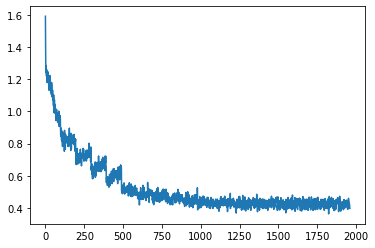

In [18]:
plt.plot(history['train_loss'])
plt.show()

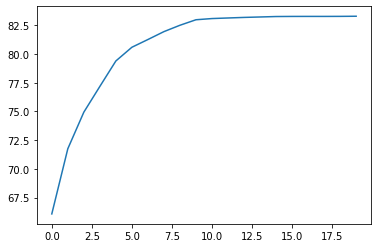

In [19]:
plt.plot(history['val_acc'])
plt.show()